In [1]:
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
props_as_ds = exp.props_as_ds(True, processes=N_WORKERS, chunksize=100)
props_as_ds_anoms = compute_anomalies_ds(props_as_ds, "dayofyear")

ds = exp.ds
jet_pos_da = jet_position_as_da(ds["s"], props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)
ds["sub_pos"] = jet_pos_da.sel(jet="subtropical")
ds["extra_pos"] = jet_pos_da.sel(jet="polar")
del jet_pos_da

da_pvs = DataHandler("ERA5", "surf", "pvs", "6H", "all", None, *dh.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da.load(**COMPUTE_KWARGS)
events = pd.read_parquet(f'{DATADIR}/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
xy_com = np.stack(events["com"].values)
valid_events_mask = (
    (xy_com[:, 0] >= dh.region[0] + 10)
    & (xy_com[:, 0] <= dh.region[1] - 10)
    & (xy_com[:, 1] >= dh.region[2] + 10)
    & (xy_com[:, 1] <= dh.region[3] - 10)
)
events = events.iloc[valid_events_mask].reset_index(drop=True)
ds["anti_pvs"] = da_pvs.sel(type="anti")
ds["cycl_pvs"] = da_pvs.sel(type="cycl")
ds = ds.reset_coords(["jet", "type"], drop=True)
da_anti = da_pvs.sel(type="anti")
da_cycl = da_pvs.sel(type="cycl")
events_mask_anti = da_anti.any(['lon', 'lat']).values
events_mask_cycl = da_cycl.any(['lon', 'lat']).values
events_indices_anti = np.where(events_mask_anti)[0]
events_indices_cycl = np.where(events_mask_cycl)[0]

# Wavebreaking relative coordinates

In [4]:
to_concat = []
for i in trange(len(events)):
    com, date = events.loc[i, ["com", "date"]]
    this_sel = ds.sel(time=date, lon=slice(com[0] - 10, com[0] + 10.1), lat=slice(com[1] - 10, com[1] + 10.1))
    this_sel = this_sel.assign_coords(lon=this_sel.lon - com[0], lat=this_sel.lat - com[1])
    to_concat.append(this_sel)
final = xr.concat(to_concat, dim="event")
final = final.assign_coords(date=("event", events["date"].values.astype("datetime64[ns]")))
coms = np.stack(events["com"].values)
final = final.assign_coords(com_x=("event", coms[:, 0]))
final = final.assign_coords(com_y=("event", coms[:, 1]))
final = final.assign_coords(mean_var=("event", events["mean_var"].values))
final = final.assign_coords(event_area=("event", events["event_area"].values))
final = final.assign_coords(intensity=("event", events["intensity"].values))

100%|██████████| 51768/51768 [01:20<00:00, 646.26it/s]


## quantile categories

In [5]:
masks = {}
q = 0.1
for coordname in ["date", "com_x", "com_y", "mean_var", "event_area", "intensity"]:
    values = final[coordname].values
    masks[f"{coordname}_low"] = values < np.quantile(values, q)
    masks[f"{coordname}_high"] = values > np.quantile(values, 1 - q)

100%|██████████| 12/12 [00:00<00:00, 28.12it/s]


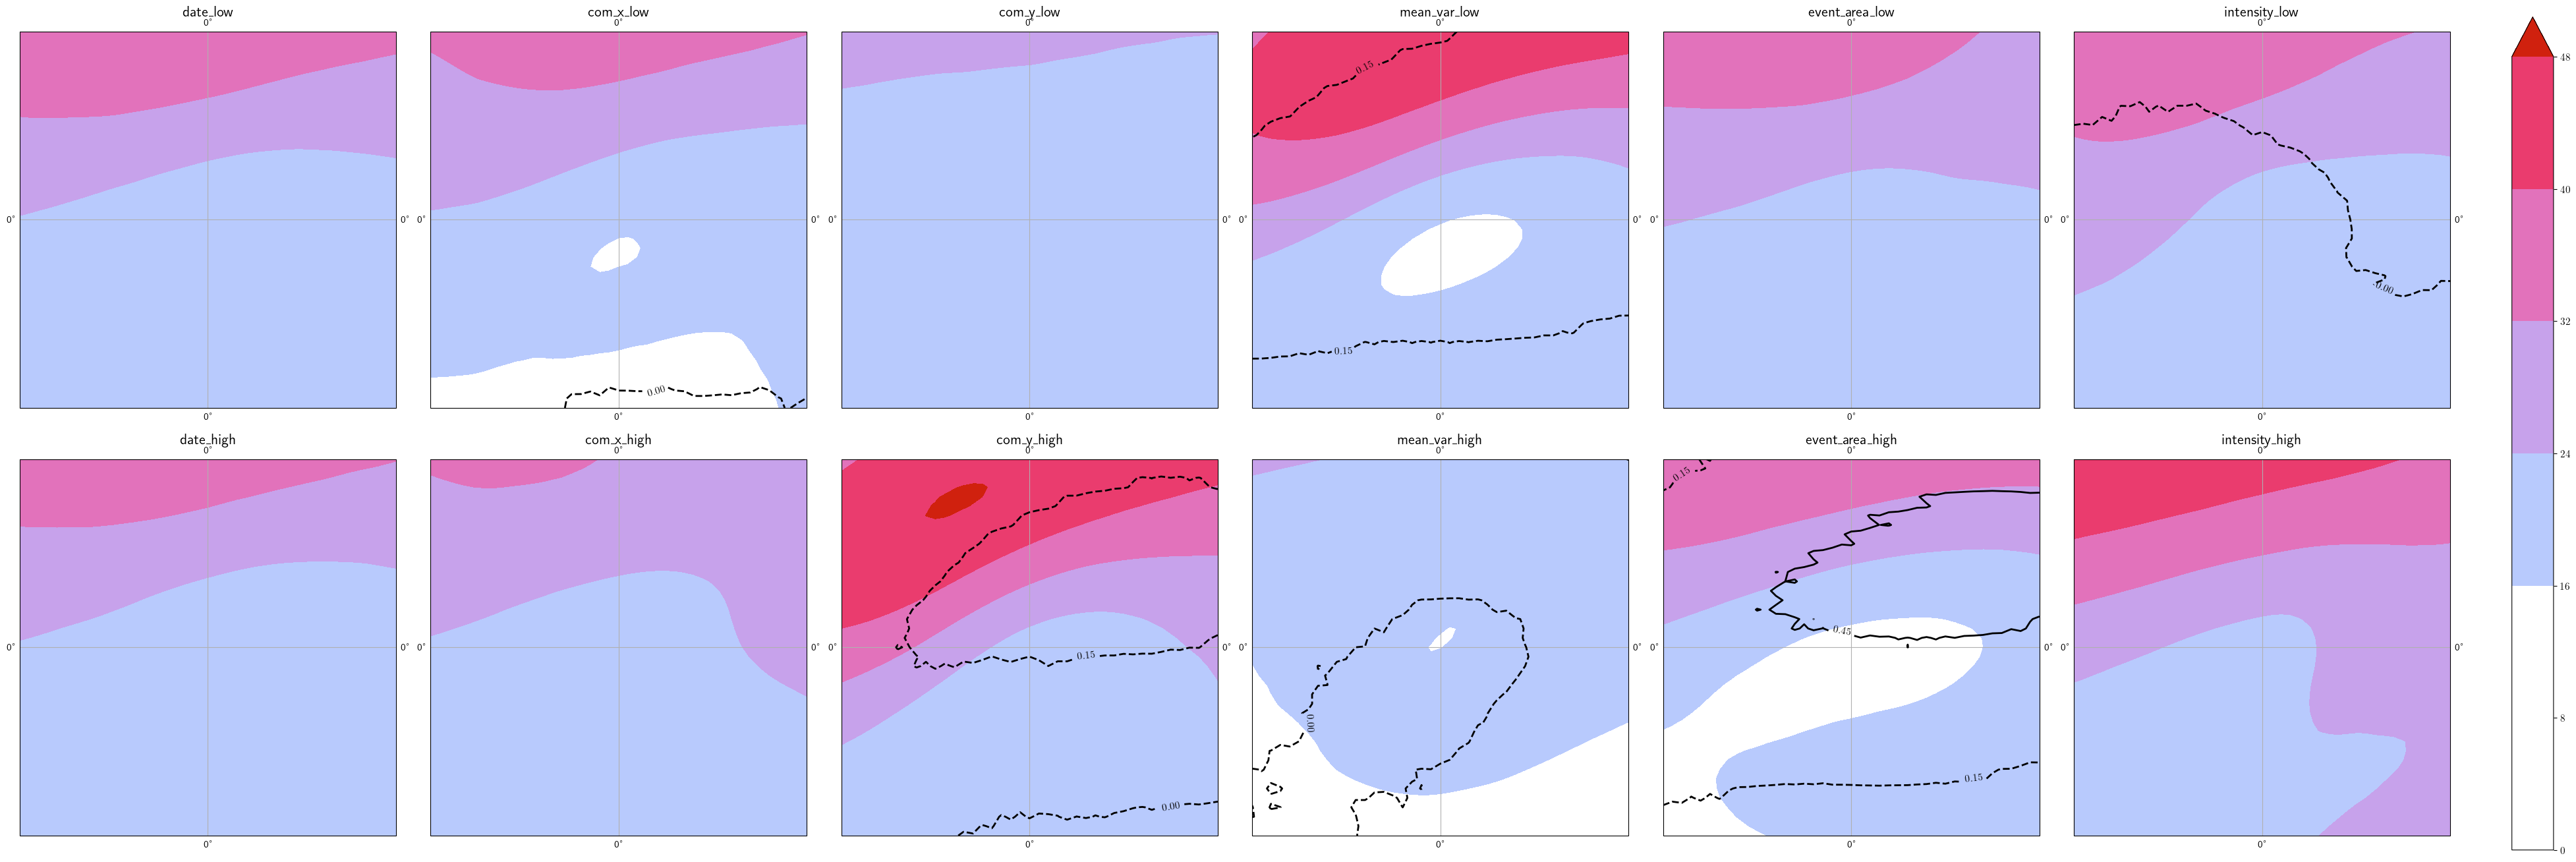

In [7]:
clu = Clusterplot(2, 6, (-10, 10, -10, 10), coastline=False)
clu._add_gridlines(step=10)
indices = np.arange(12).reshape(6, 2).transpose().flatten()
mask_values = np.asarray(list(masks.values()))[indices].T
titles = np.asarray(list(masks))[indices]
_ = clu.add_any_contour_from_mask(final["s"], mask_values, titles=titles, cmap=colormaps.cet_l_wcmr, levels=7, cbar_kwargs={"pad": 0.02}, transparify=2)
_ = clu.add_any_contour_from_mask(final["anti_pvs"], mask_values, type="contour", titles=titles, clabels=True, levels=4)

## clustering

In [45]:
final_anti = final.sel(event=final.intensity.values>=0)
X = final_anti["s"].values.reshape(len(final_anti.event), -1)
X[np.isnan(X)] = 0
labels = KMeans(12).fit_predict(X)
masks = labels_to_mask(labels)

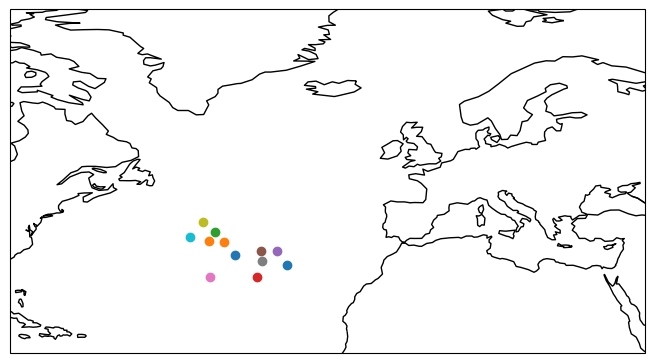

In [46]:
clu = Clusterplot(1, 1, exp.region)
for mask in masks.T:
    x, y = np.vstack(final_anti.com[mask].values.tolist()).mean(axis=0)
    clu.axes[0].scatter(x, y)

100%|██████████| 12/12 [00:00<00:00, 42.61it/s]


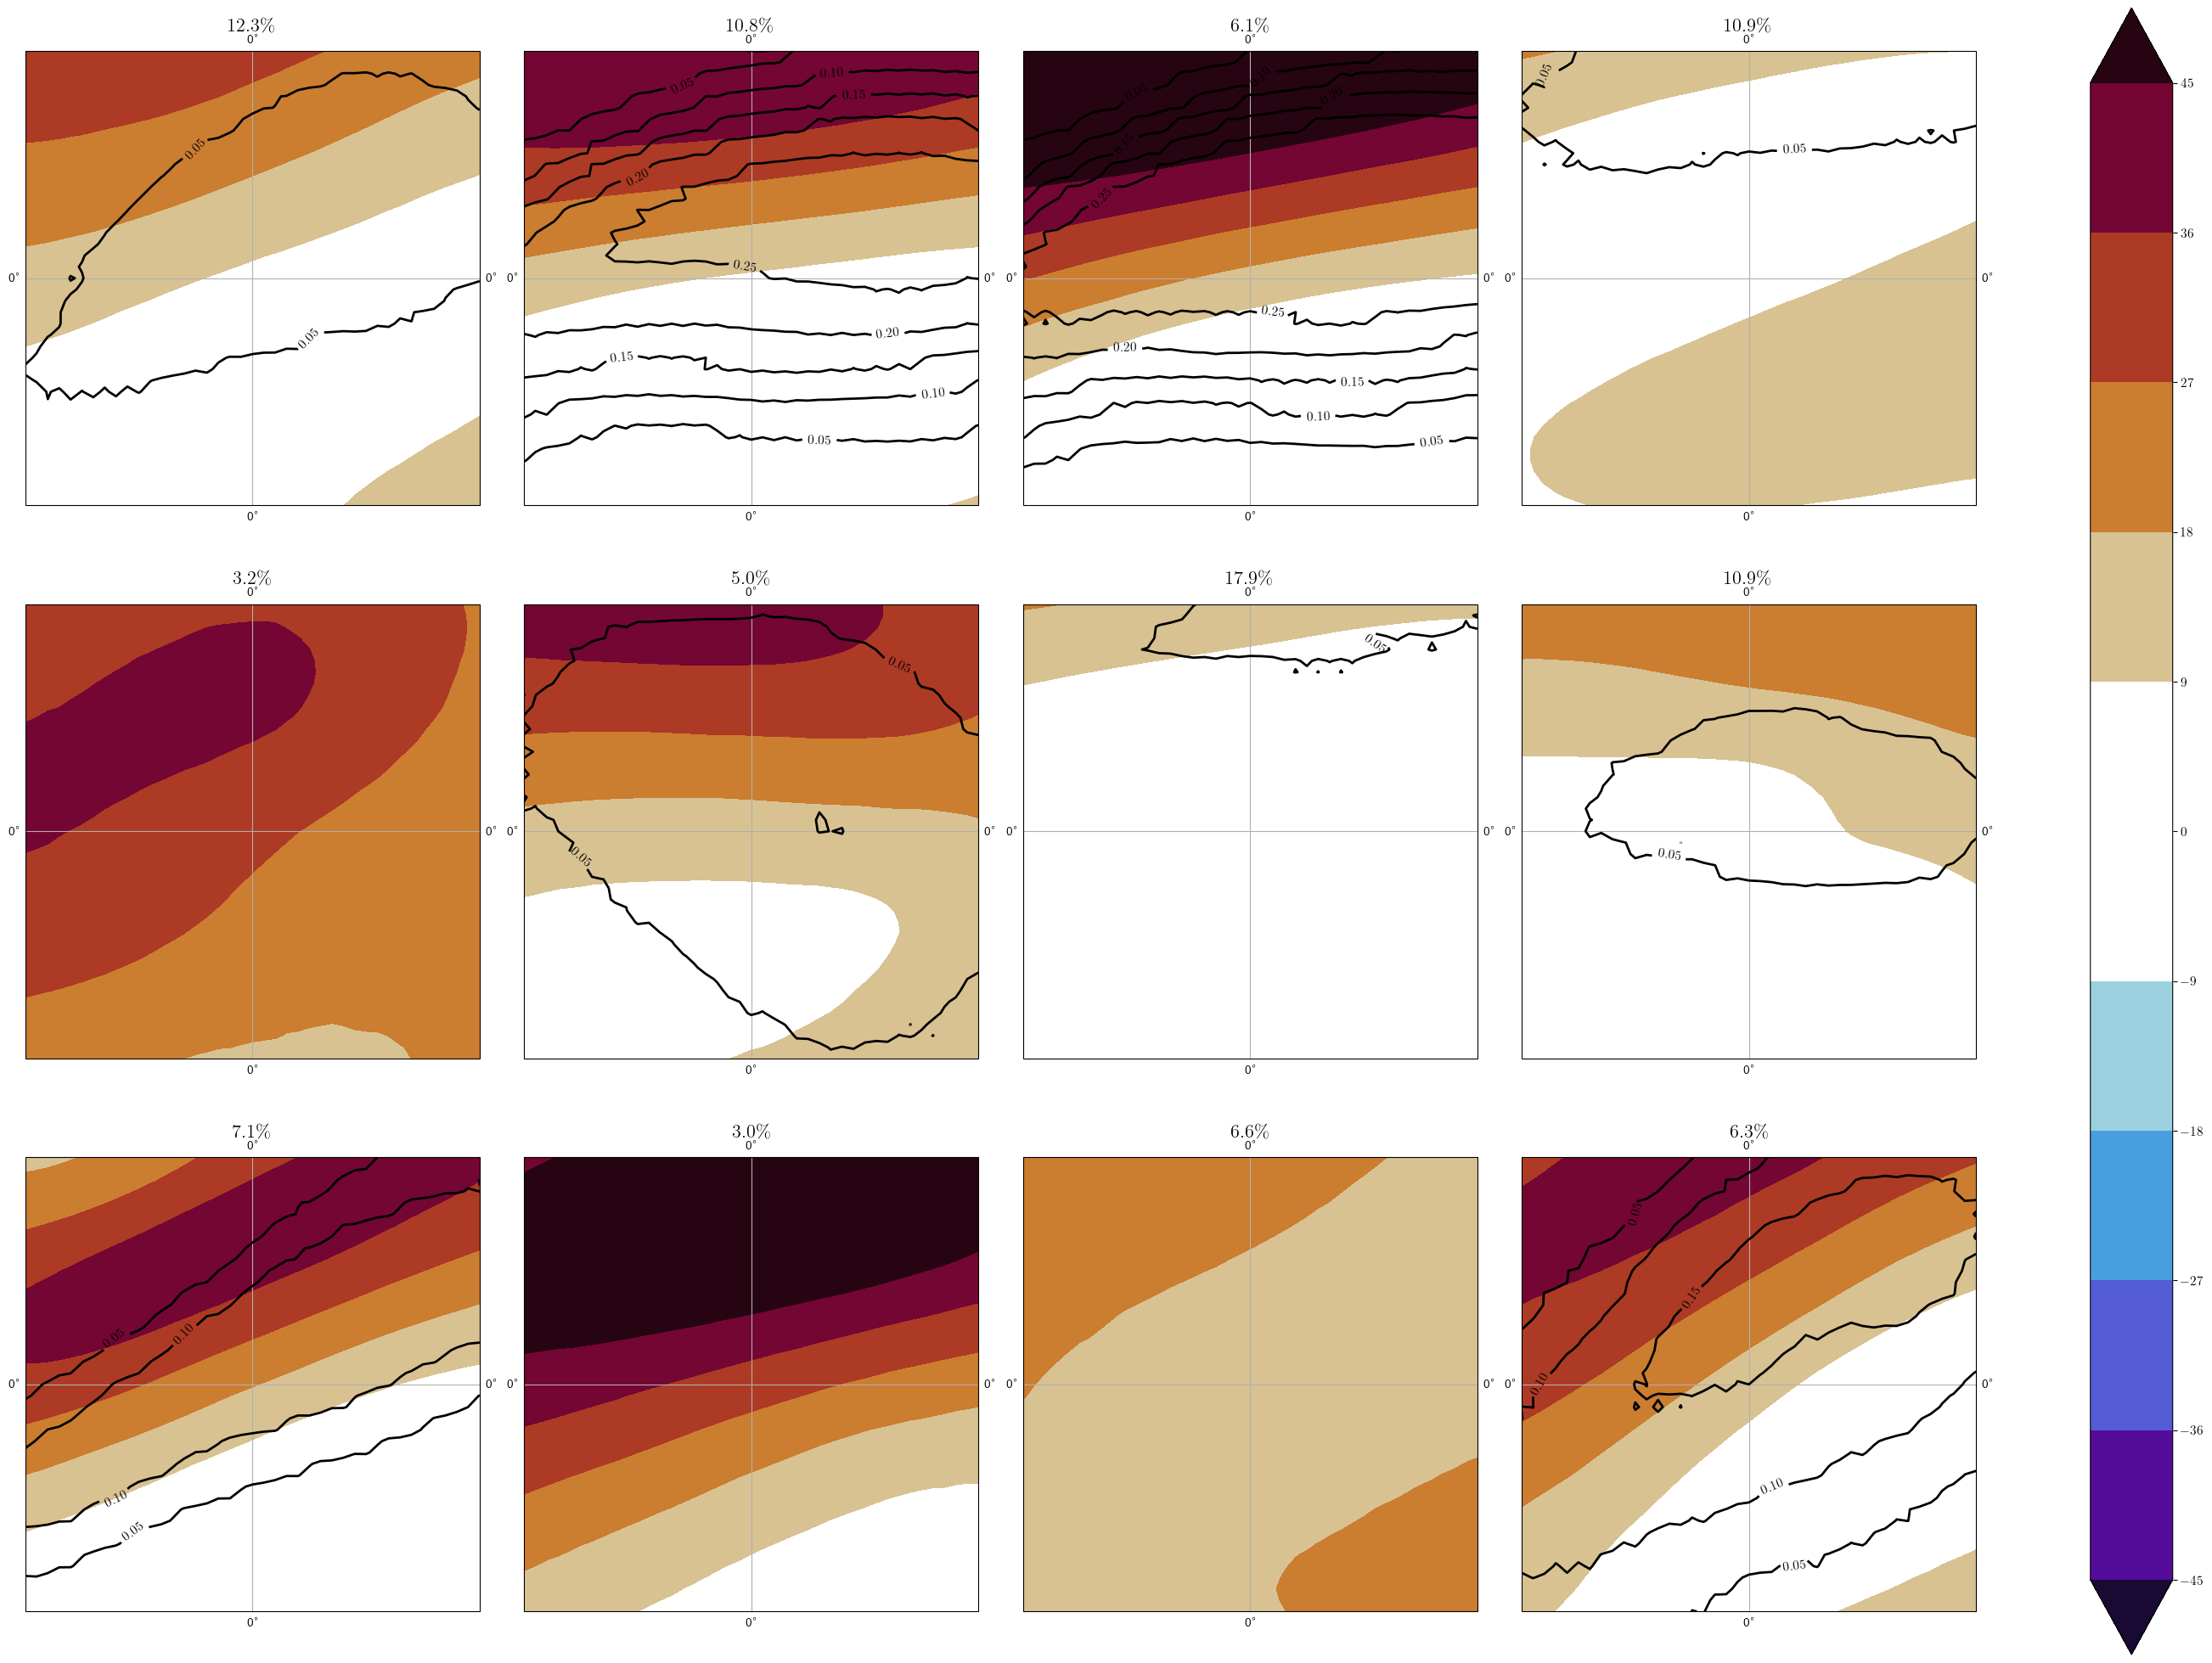

In [47]:
clu = Clusterplot(3, 4, (-10, 10, -10, 10), coastline=False)
clu._add_gridlines(step=10)
titles = [f"${a * 100:.1f}" + r"\%$" for a in np.mean(masks, axis=0)]
_ = clu.add_any_contour_from_mask(final_anti["u"], masks, q=0.95, titles=titles)
_ = clu.add_any_contour_from_mask(final_anti["anti_pvs"], masks, type="contour", q=0.95, clabels=True)

100%|██████████| 12/12 [00:00<00:00, 40.46it/s]


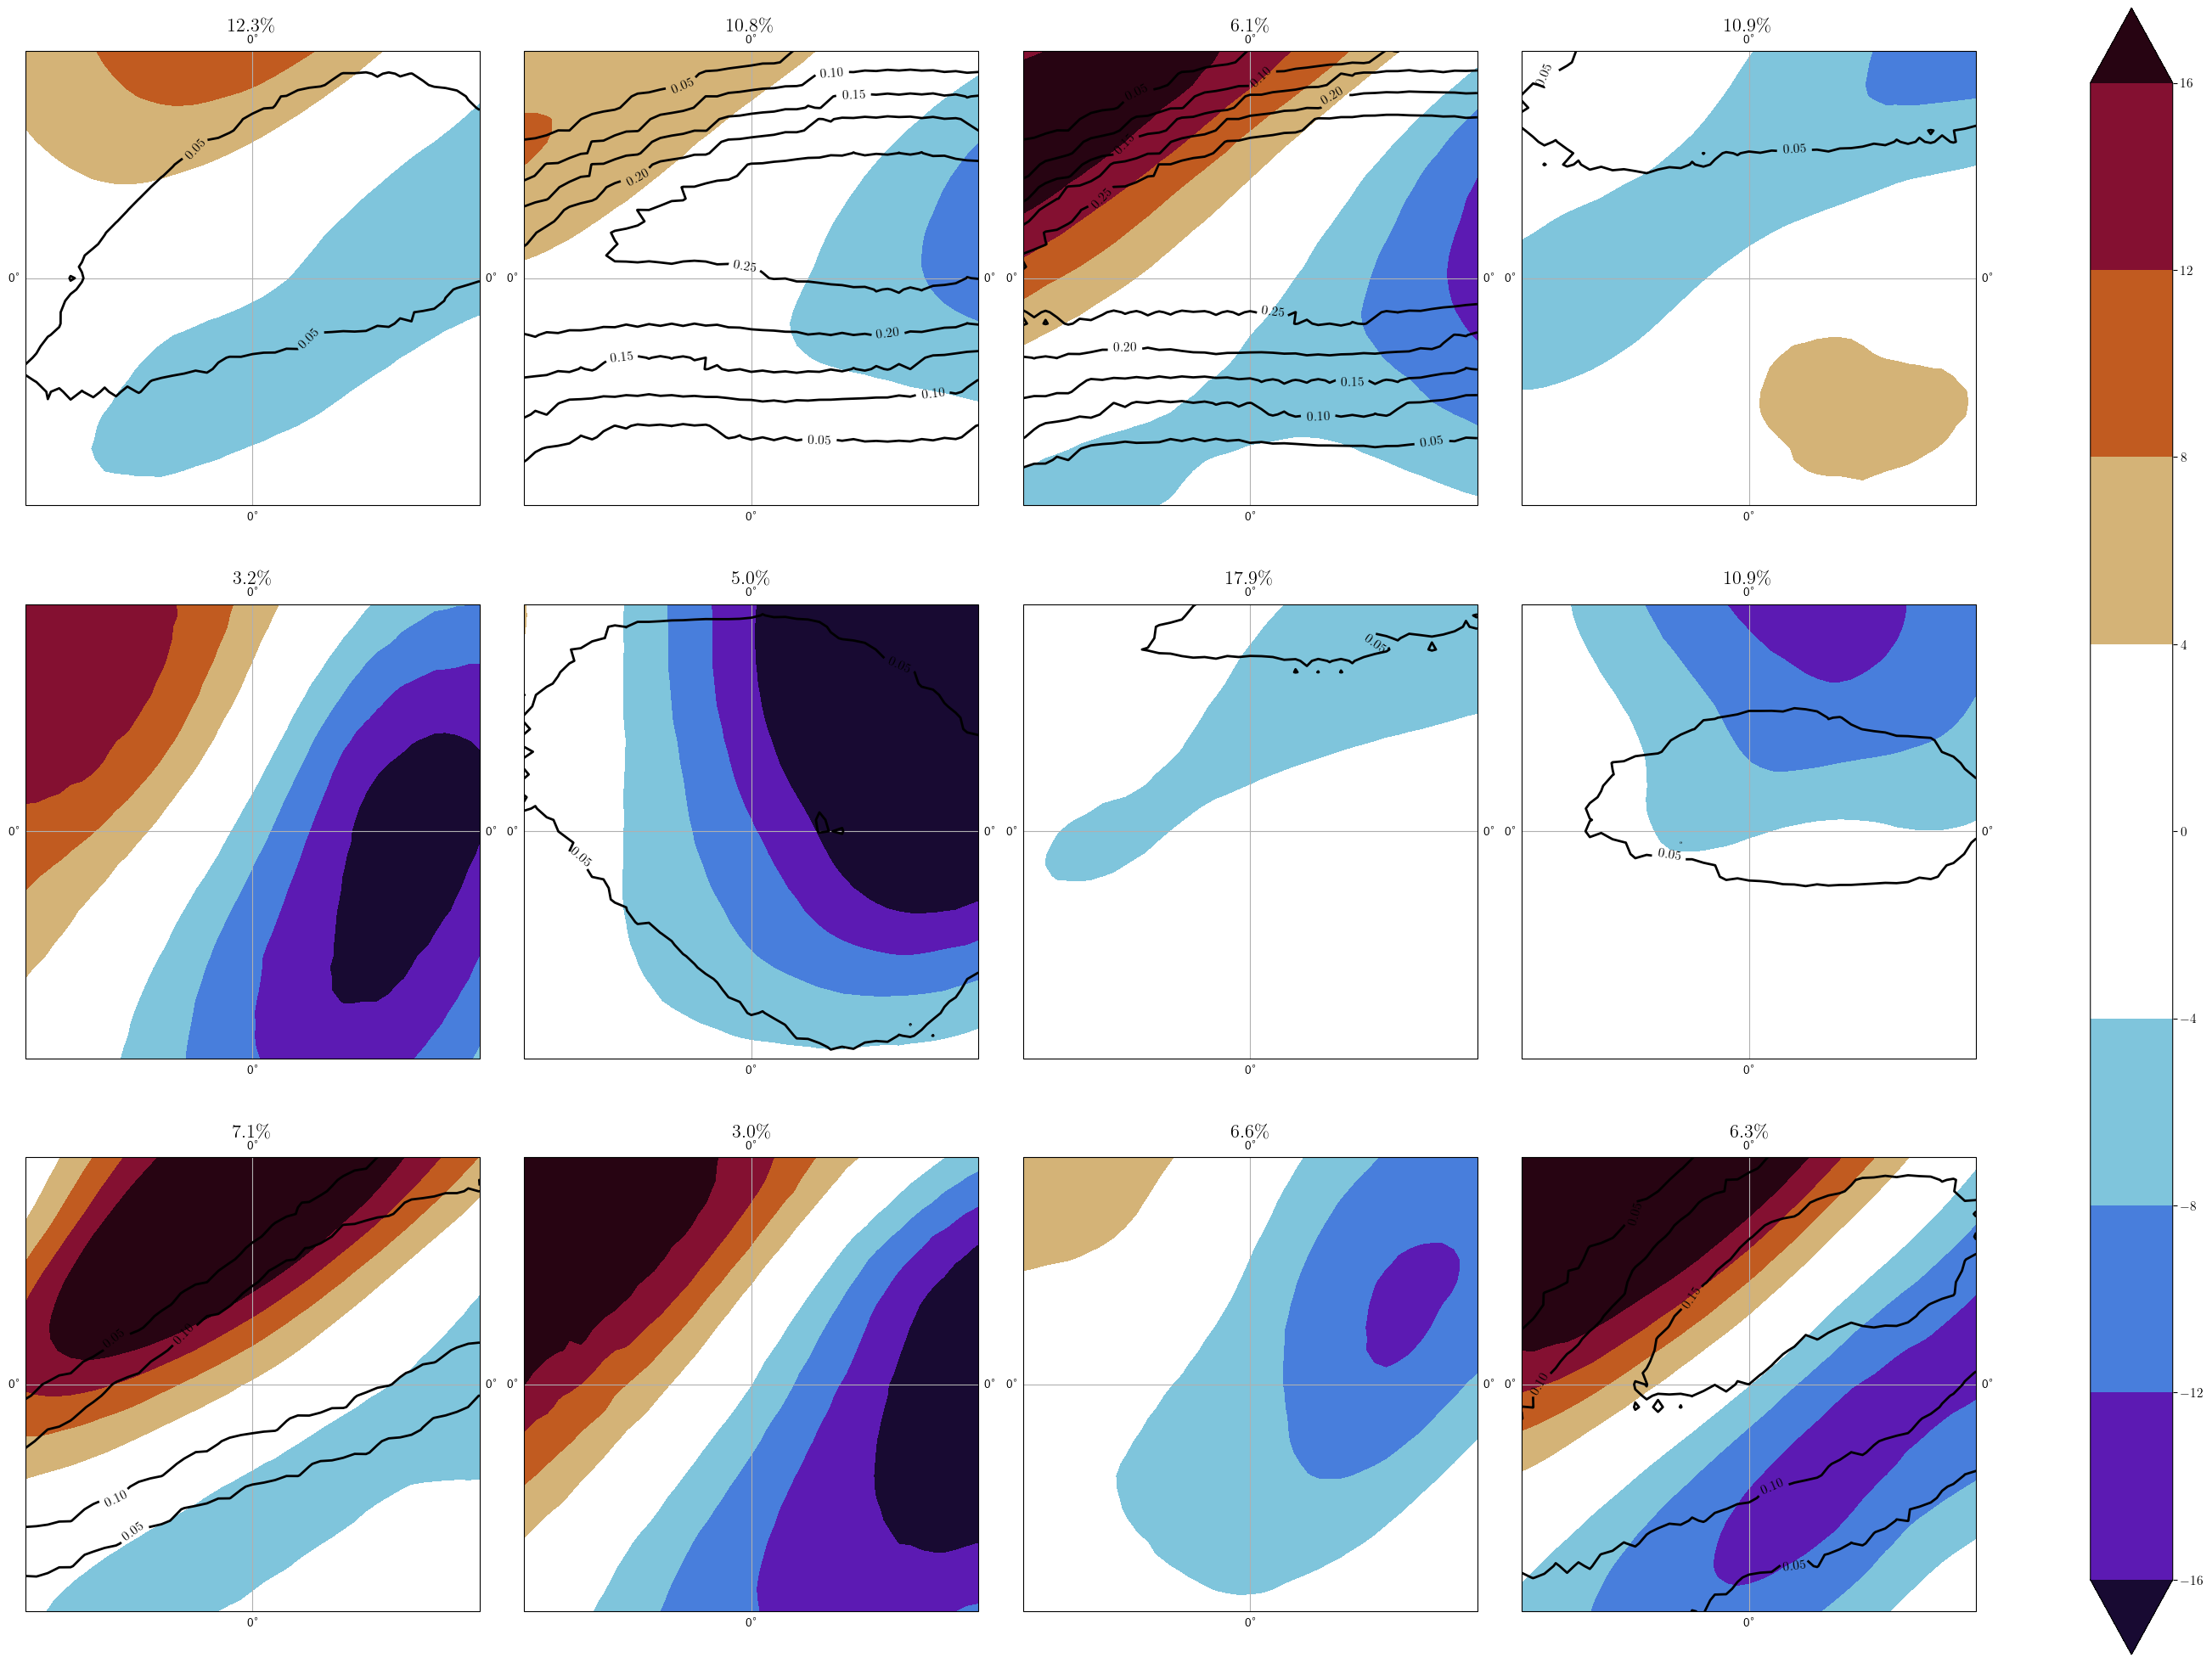

In [48]:
clu = Clusterplot(3, 4, (-10, 10, -10, 10), coastline=False)
clu._add_gridlines(step=10)

titles = [f"${a * 100:.1f}" + r"\%$" for a in np.mean(masks, axis=0)]
_ = clu.add_any_contour_from_mask(final_anti["v"], masks, q=0.95, titles=titles)
_ = clu.add_any_contour_from_mask(final_anti["anti_pvs"], masks, type="contour", q=0.95, clabels=True)

100%|██████████| 12/12 [00:00<00:00, 40.62it/s]


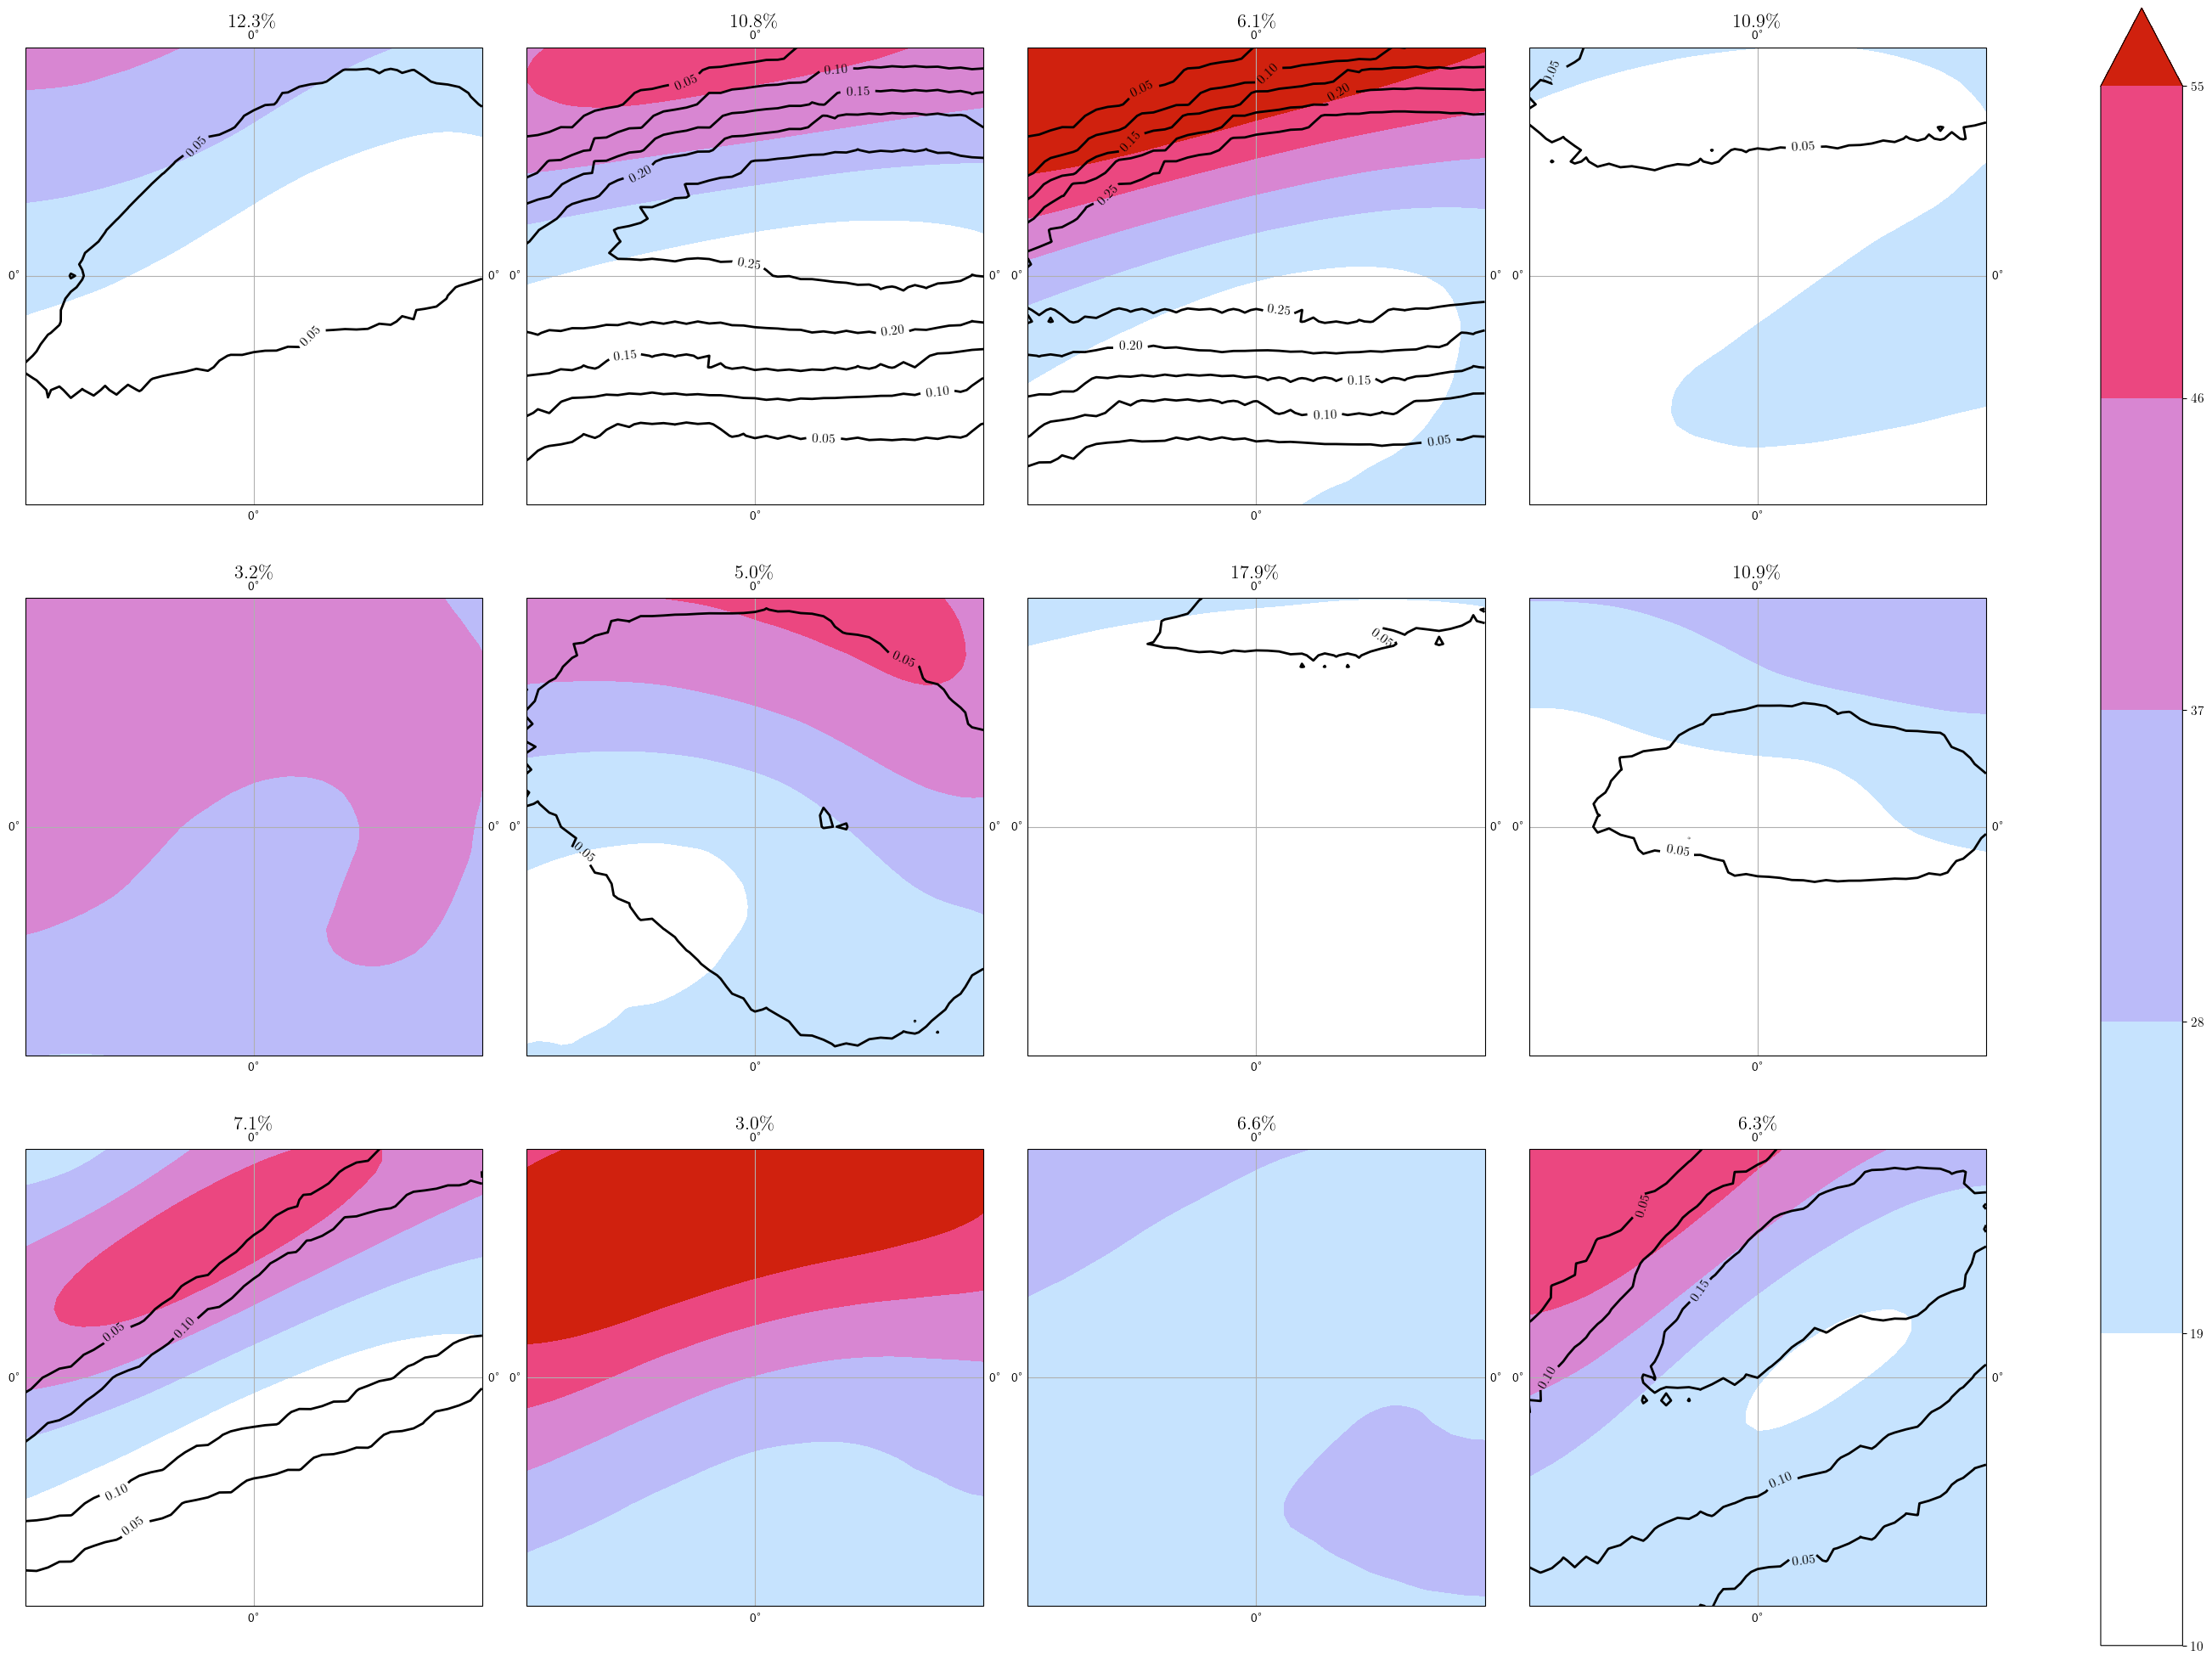

In [49]:
clu = Clusterplot(3, 4, (-10, 10, -10, 10), coastline=False)
clu._add_gridlines(step=10)

titles = [f"${a * 100:.1f}" + r"\%$" for a in np.mean(masks, axis=0)]
_ = clu.add_any_contour_from_mask(final_anti["s"], masks, q=0.95, titles=titles, cmap=colormaps.cet_l_wcmr, transparify=1)
_ = clu.add_any_contour_from_mask(final_anti["anti_pvs"], masks, type="contour", q=0.95, clabels=True)

In [ ]:
ints = wb_props_uncat["mean_int"]
ints_ = ints.values
q_highpos = np.quantile(ints_[ints_ > 0], 0.9)
q_highneg = np.quantile(ints_[ints_ < 0], 0.1)
subset_uncat = props_as_ds_uncat.where(ints <= q_highneg)
subset_cat = categorize_ds_jets(subset_uncat)
subset_anoms = compute_anomalies_ds(subset_cat, "dayofyear", normalized=False)
subset_anoms.mean(dim="time")

<xarray.Dataset> Size: 408B
Dimensions:          (jet: 2)
Coordinates:
  * jet              (jet) <U11 88B 'subtropical' 'polar'
Data variables: (12/20)
    mean_lon         (jet) float64 16B 0.232 0.2856
    mean_lat         (jet) float64 16B 0.2622 0.3594
    mean_lev         (jet) float64 16B 0.0426 0.8084
    mean_spe         (jet) float64 16B 0.1956 0.2659
    lon_star         (jet) float64 16B 0.9997 0.1417
    lat_star         (jet) float64 16B 0.4984 0.3289
    ...               ...
    wavinessFV15     (jet) float64 16B 0.001287 0.000425
    width            (jet) float64 16B -3.645e+03 -3.045e+03
    int_over_europe  (jet) float64 16B 3.514e+06 1.225e+06
    int              (jet) float64 16B 5.139e+06 5.356e+06
    persistence      (jet) float64 16B 0.3866 0.1212
    com_speed        (jet) float64 16B -0.4179 0.005546

100%|██████████| 12/12 [00:00<00:00, 45.10it/s]


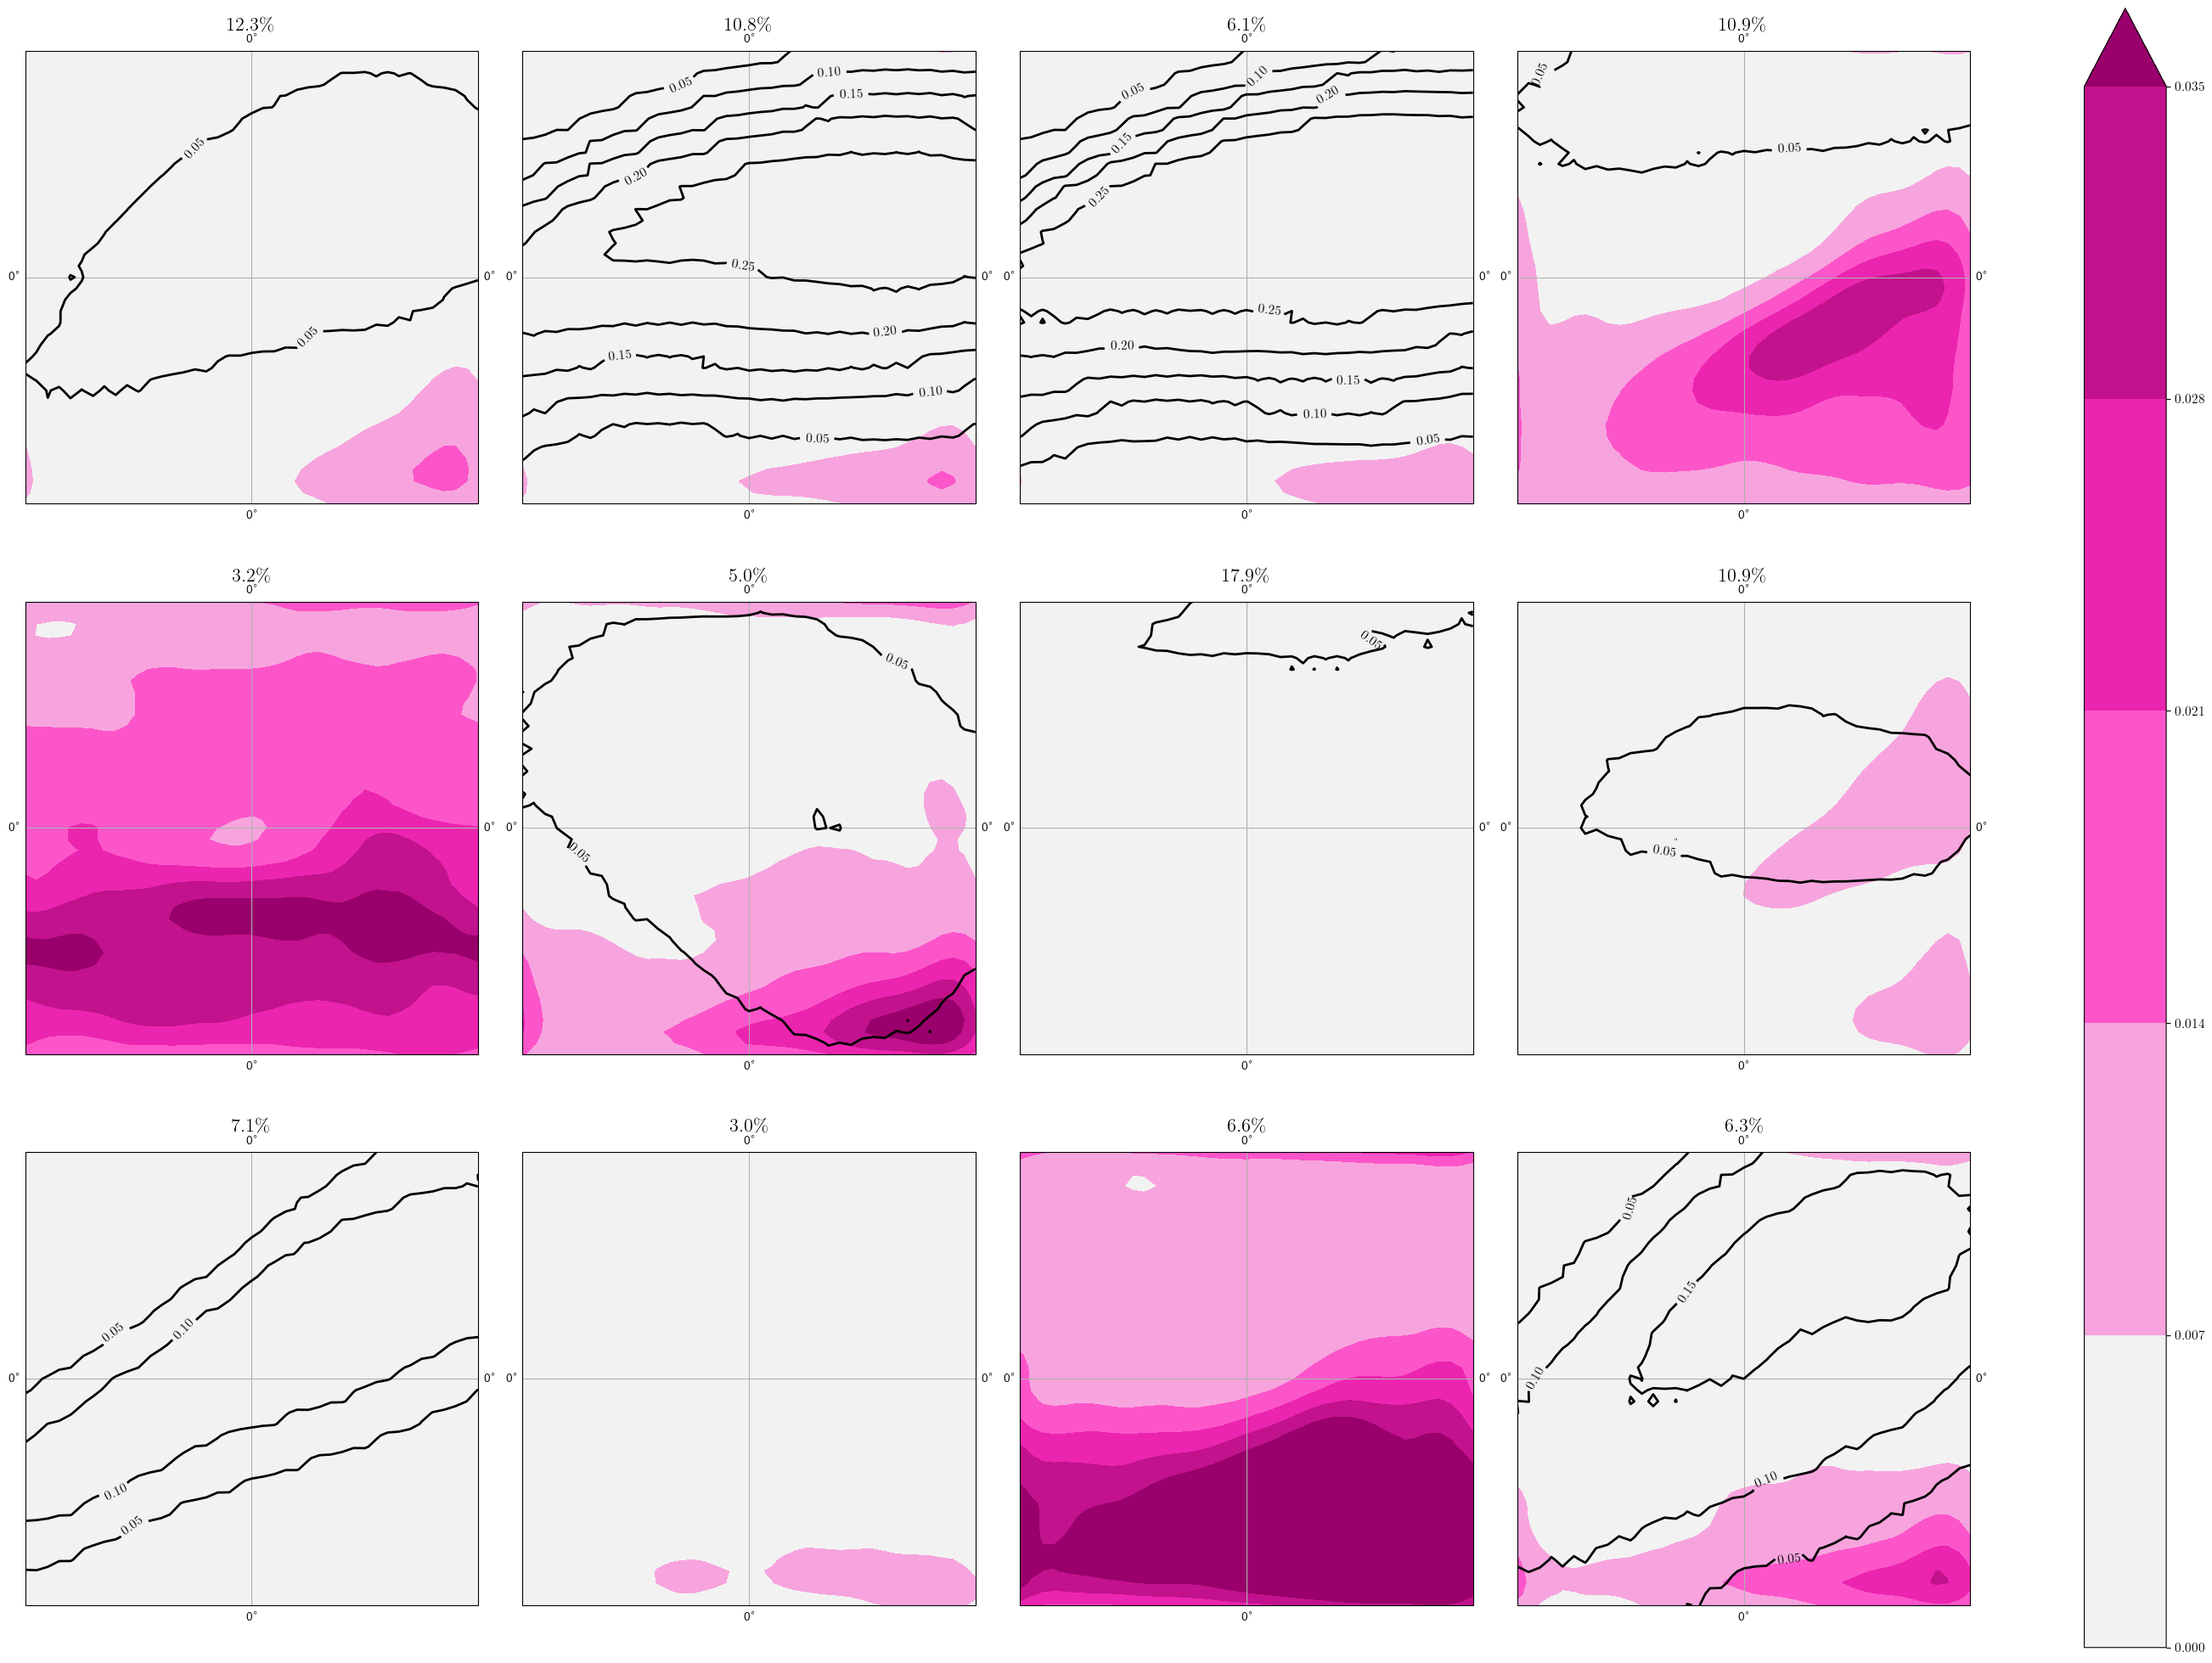

In [50]:
clu = Clusterplot(3, 4, (-10, 10, -10, 10), coastline=False)
clu._add_gridlines(step=10)

titles = [f"${a * 100:.1f}" + r"\%$" for a in np.mean(masks, axis=0)]
da_jet_pos_ = smooth(final_anti["sub_pos"], {"lon+lat": ("fft", 0.3)})
_ = clu.add_any_contour_from_mask(da_jet_pos_.where(da_jet_pos_ > 0, 0), masks, q=0.95, titles=titles, cmap=MYPINKS)
_ = clu.add_any_contour_from_mask(final_anti["anti_pvs"], masks, type="contour", q=0.95, clabels=True)

100%|██████████| 12/12 [00:00<00:00, 45.94it/s]


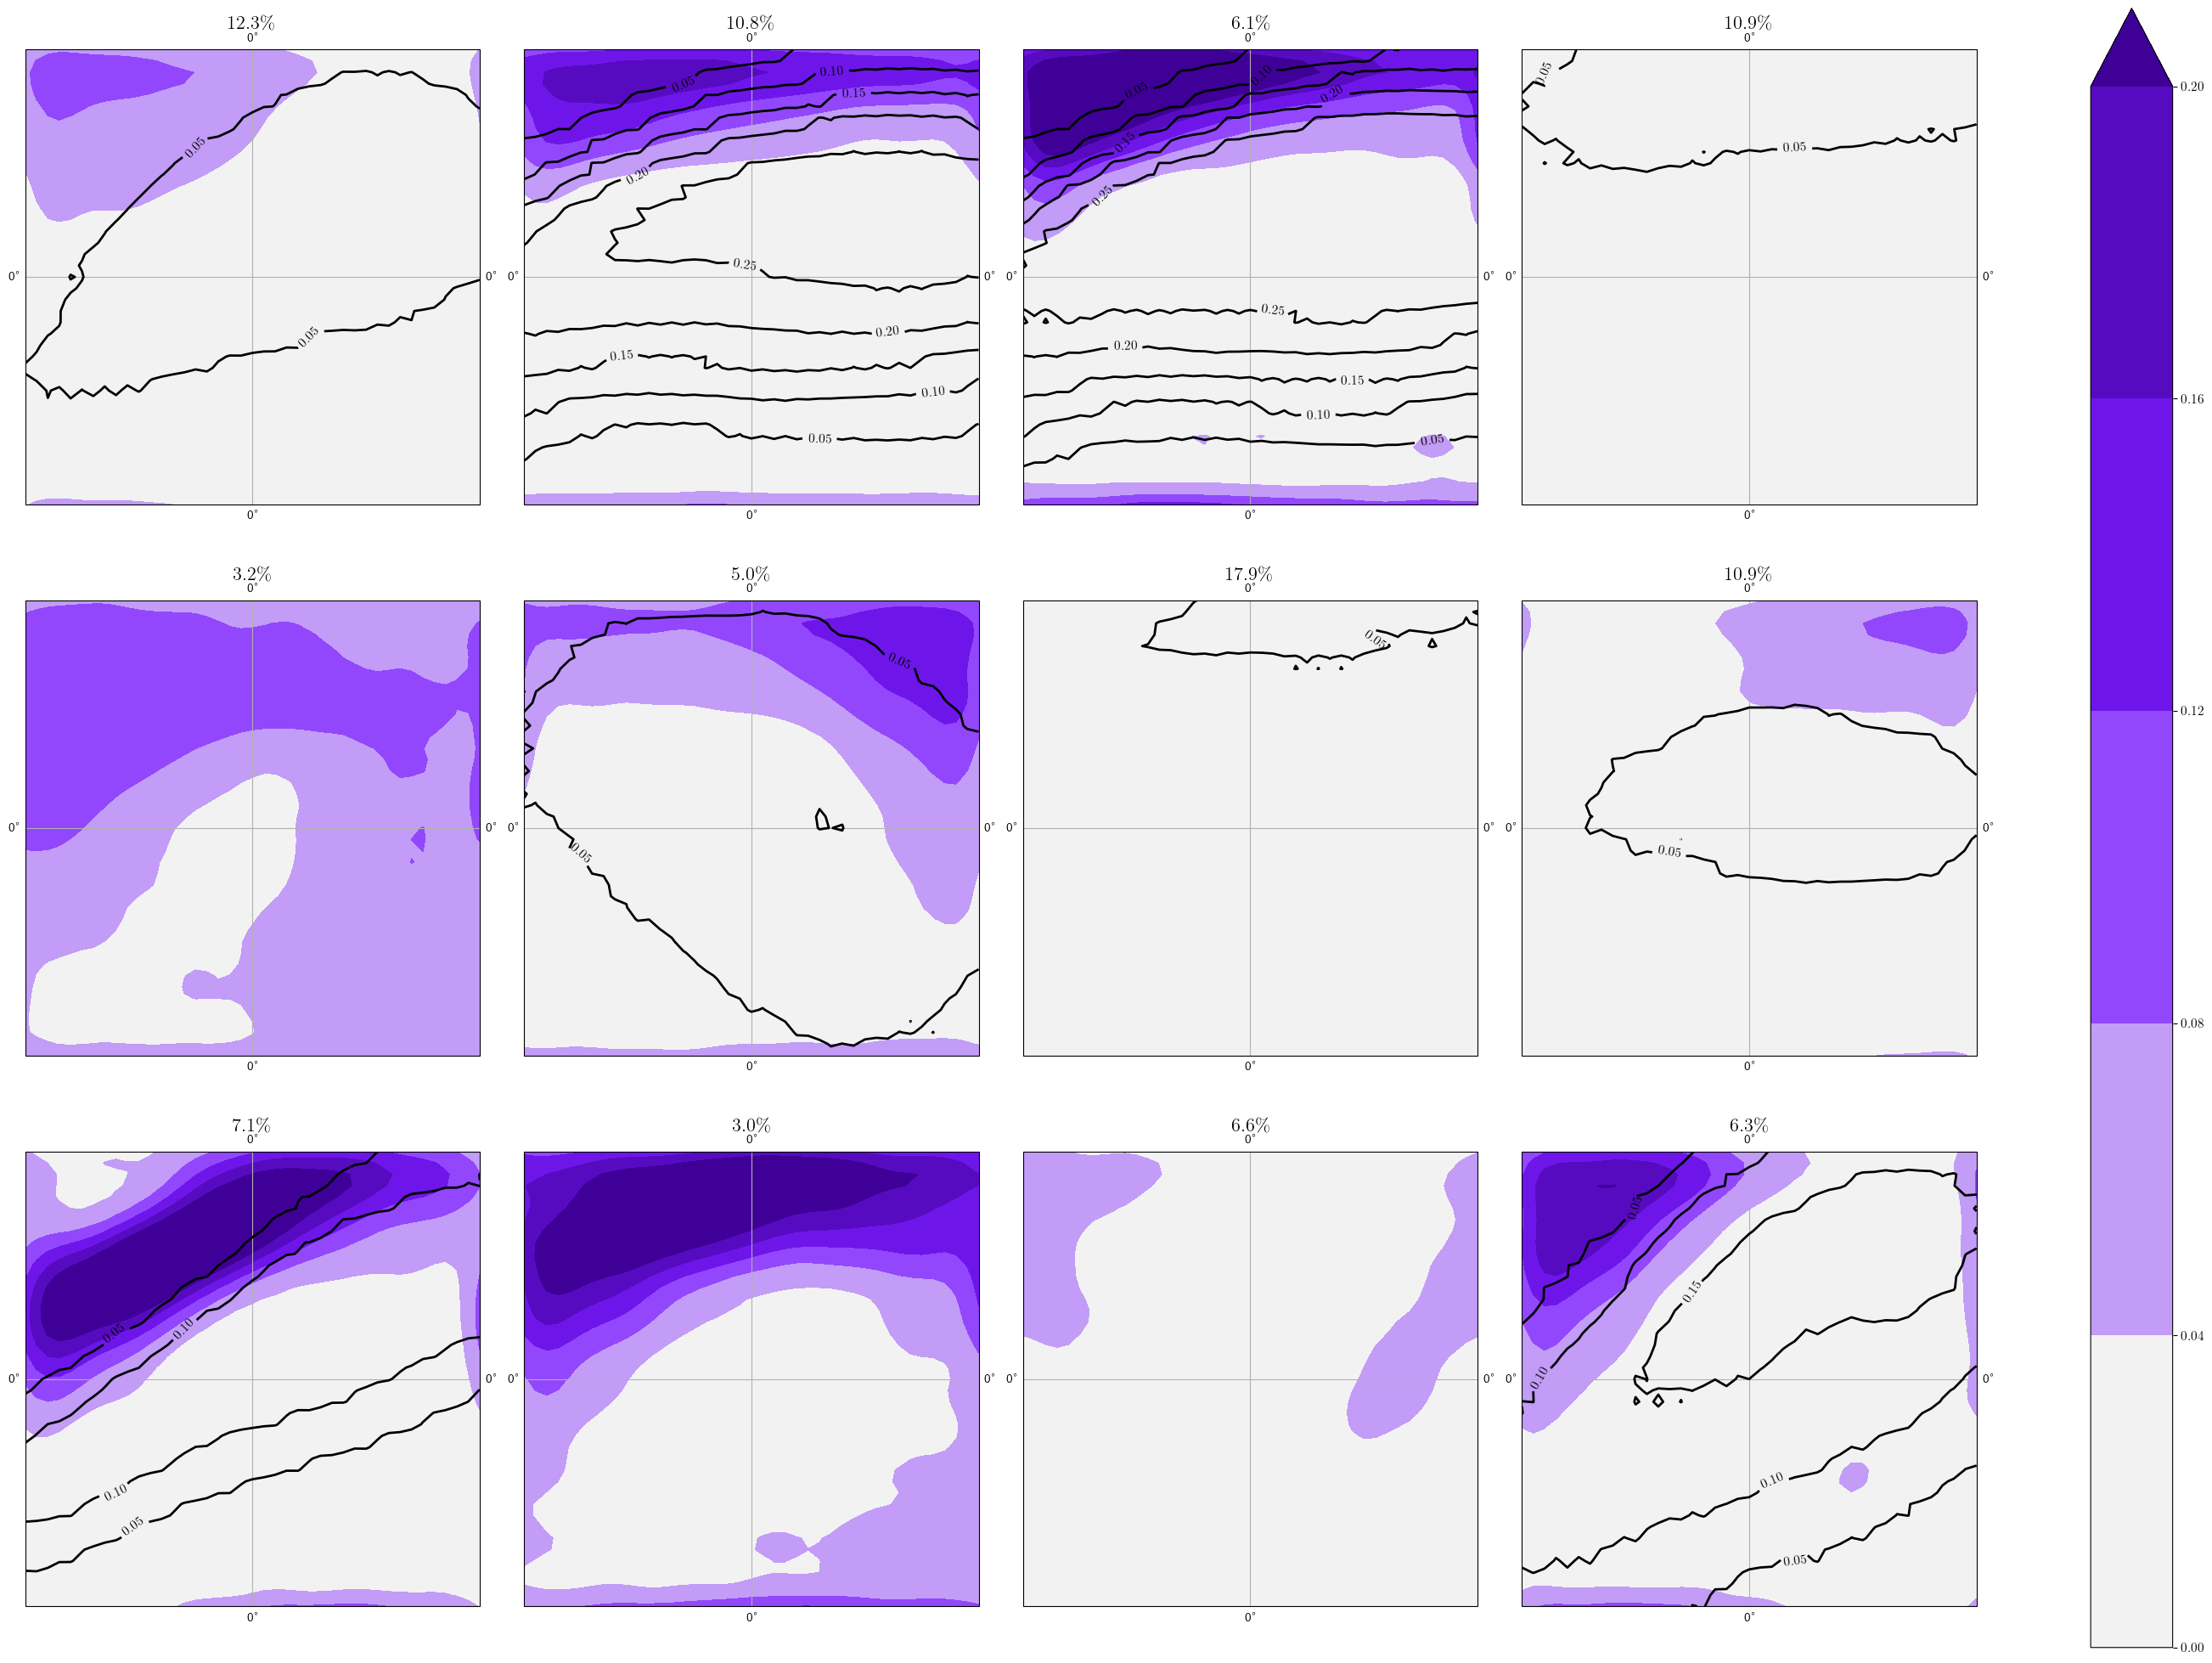

In [51]:
clu = Clusterplot(3, 4, (-10, 10, -10, 10), coastline=False)
clu._add_gridlines(step=10)

titles = [f"${a * 100:.1f}" + r"\%$" for a in np.mean(masks, axis=0)]
da_jet_pos_ = smooth(final_anti["extra_pos"], {"lon+lat": ("fft", 0.3)})
_ = clu.add_any_contour_from_mask(da_jet_pos_.where(da_jet_pos_ > 0, 0), masks, q=0.95, titles=titles, cmap=MYPURPLES)
_ = clu.add_any_contour_from_mask(final_anti["anti_pvs"], masks, type="contour", q=0.95, clabels=True)

# Event near jet like width

In [3]:
wb_props_uncat = compute_all_wb_props(all_jets_one_df, da_pvs, event_mask=events_mask_anti | events_mask_cycl, processes=20)

Computing wb properties


100%|██████████| 93504/93504 [36:11<00:00, 43.06it/s] 


In [4]:
wb_props_uncat.to_netcdf(exp.path.joinpath("wb_props_uncat.nc"))

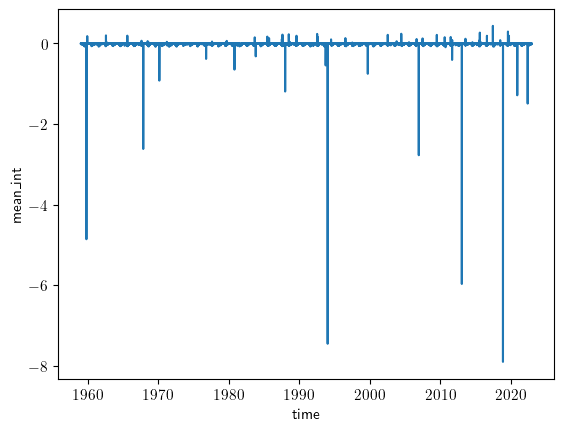

In [ ]:
wb_props_uncat["mean_int"].min("jet").plot()

In [ ]:
ints = wb_props_uncat["mean_int"]
ints_ = ints.values
q_highpos = np.quantile(ints_[ints_ > 0], 0.9)
q_highneg = np.quantile(ints_[ints_ < 0], 0.1)
subset_uncat = props_as_ds_uncat.where(ints <= q_highneg)
subset_cat = categorize_ds_jets(subset_uncat)
subset_anoms = compute_anomalies_ds(subset_cat, "dayofyear", normalized=True)
subset_anoms.mean(dim="time")

<xarray.Dataset> Size: 408B
Dimensions:          (jet: 2)
Coordinates:
  * jet              (jet) <U11 88B 'subtropical' 'polar'
Data variables: (12/20)
    mean_lon         (jet) float64 16B 0.232 0.2856
    mean_lat         (jet) float64 16B 0.2622 0.3594
    mean_lev         (jet) float64 16B 0.0426 0.8084
    mean_spe         (jet) float64 16B 0.1956 0.2659
    lon_star         (jet) float64 16B 0.9997 0.1417
    lat_star         (jet) float64 16B 0.4984 0.3289
    ...               ...
    wavinessFV15     (jet) float64 16B 0.001287 0.000425
    width            (jet) float64 16B -3.645e+03 -3.045e+03
    int_over_europe  (jet) float64 16B 3.514e+06 1.225e+06
    int              (jet) float64 16B 5.139e+06 5.356e+06
    persistence      (jet) float64 16B 0.3866 0.1212
    com_speed        (jet) float64 16B -0.4179 0.005546

In [82]:
(props_as_ds_uncat.where(ints >= q_highpos)["is_polar"] == 0.).std()

<xarray.DataArray 'is_polar' ()> Size: 8B
array(0.00595)

# With mask_pvs

In [76]:
def mask_pvs(
    da: xr.DataArray | xr.Dataset,
    events: pd.DataFrame,
    da_anti: xr.DataArray,
    offsets: Sequence | None = None,
    q: float = 0.9,
) -> xr.DataArray:
    if offsets is None:
        offsets = np.arange(24)
    da_masked = None
    for offset in tqdm(offsets):
        if da_masked is None:
            events_ = events.iloc[events["date"].isin(da_anti.time.values[events_mask]).values]
            events_com_x = np.stack(events_["com"].values)[:, 0]
            events_com_y = np.stack(events_["com"].values)[:, 1]
            masks = {
                "west": events_com_x < np.quantile(events_com_x, 1 - q),
                "east": events_com_x > np.quantile(events_com_x, q),
                "south": events_com_y < np.quantile(events_com_y, 1 - q),
                "north": events_com_y > np.quantile(events_com_y, q),
                "intense": (
                    events_["intensity"] > np.quantile(events_["intensity"], q)
                ).values,
                "large": (
                    events_["event_area"] > np.quantile(events_["event_area"], q)
                ).values,
            }
            base_coords = {dim: getattr(da, dim).values for dim in da.dims if dim != "time"}
            coords = {
                "event_type": ["all"] + list(masks),
                "time_around_event": offsets,
            } | base_coords
            da_masked = xr.DataArray(
                data=np.zeros([len(c) for c in coords.values()]) + np.nan, coords=coords
            )
            if isinstance(da, xr.Dataset):
                da_masked = xr.Dataset({varname: da_masked.copy() for varname in da.data_vars})
            masks["all"] = np.ones_like(masks["west"], dtype=bool)
        for event_type, mask in masks.items():
            if event_type == "all":
                times = np.unique(events_["date"]) + offset * np.timedelta64(6, "h")
            else:
                times = np.unique(events_[mask]["date"]) + offset * np.timedelta64(6, "h")
            times = times[np.isin(times, da.time)]
            da_masked.loc[dict(event_type=event_type, time_around_event=offset)] = da.loc[dict(time=times)].mean(dim="time")
    return da_masked

In [66]:
da_masked = mask_pvs(da, events, da_anti, offsets=np.arange(0, 25, 4))

100%|██████████| 7/7 [03:58<00:00, 34.04s/it]


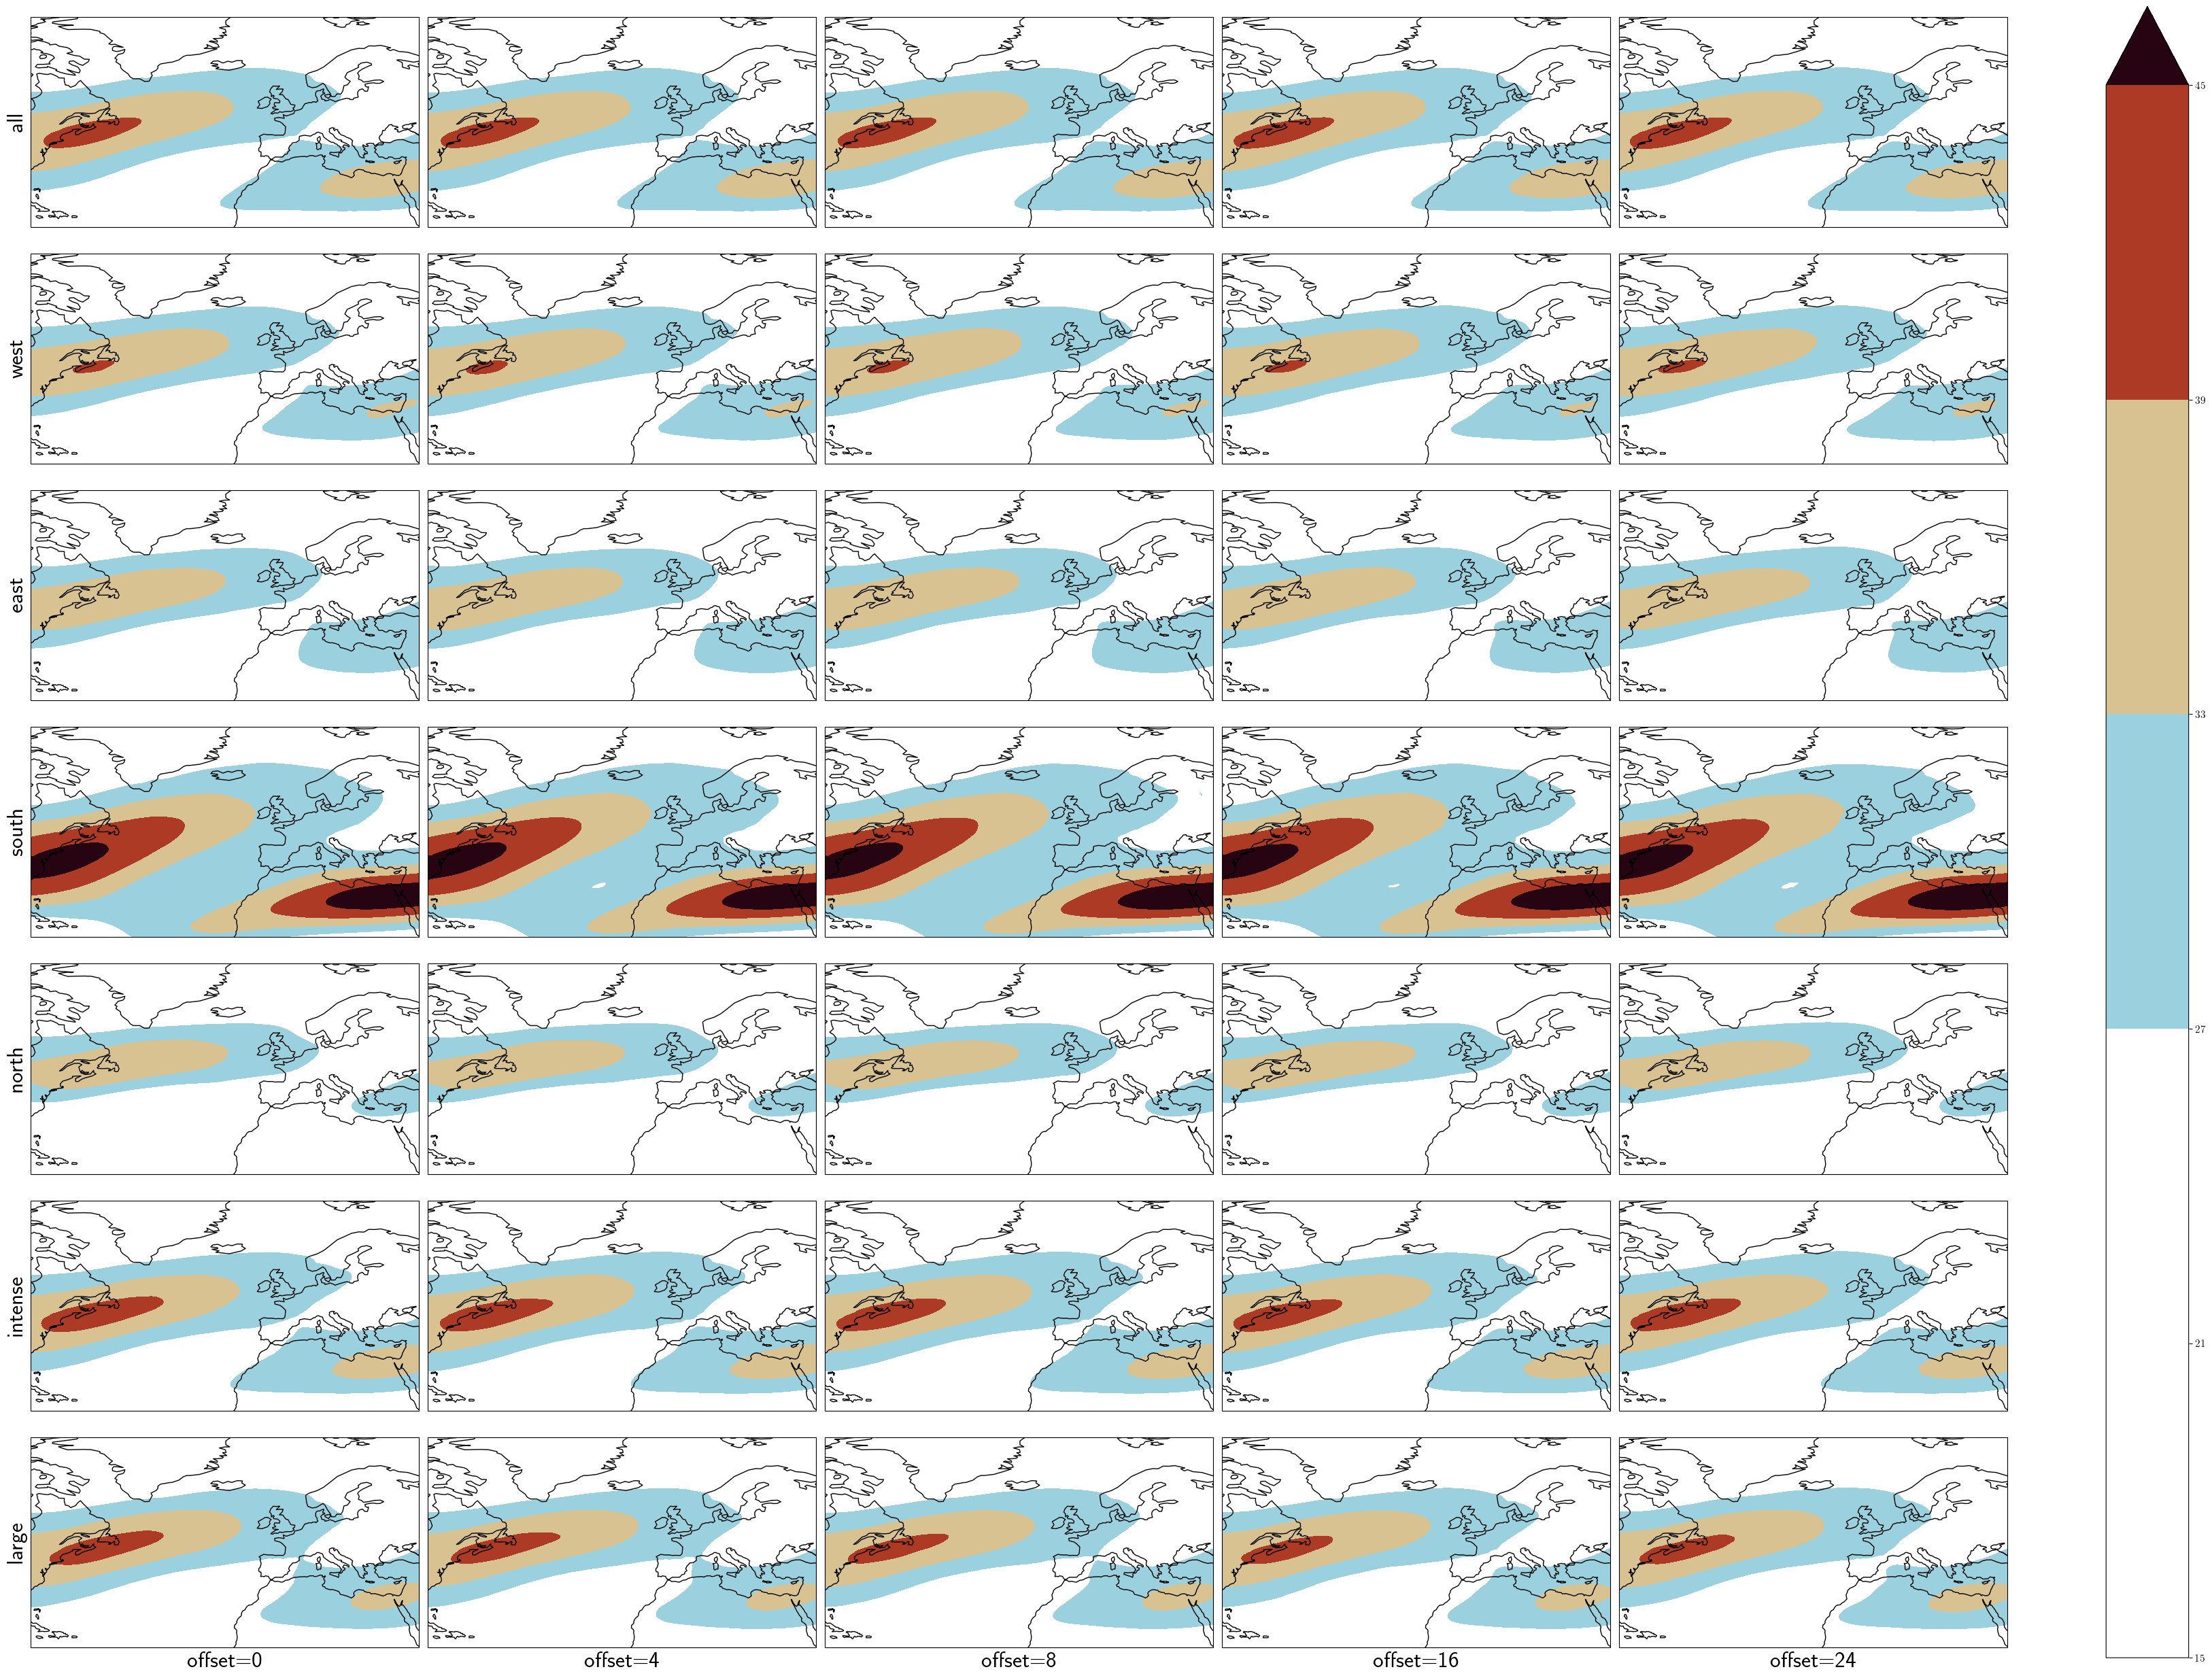

In [67]:
offsets = [0, 4, 8, 16, 24]
clu = Clusterplot(len(da_masked.event_type), len(offsets), region=get_region(da_masked))
_ = clu.add_contourf([da_masked.loc[event_type, offset] for event_type in da_masked.event_type for offset in offsets], transparify=2, q=0.99)
for i, event_type in enumerate(da_masked.event_type.values):
    k = len(offsets) * i
    clu.axes[k].set_yticks([])
    clu.axes[k].set_ylabel(event_type, fontsize=24)
for i, offset in enumerate(offsets):
    k = len(offsets) * (len(da_masked.event_type) - 1) + i
    clu.axes[k].set_xticks([])
    clu.axes[k].set_xlabel(f"{offset=}", fontsize=24)

In [68]:
da_jp_masked = mask_pvs(jet_pos_da, events, da_anti)

100%|██████████| 24/24 [01:33<00:00,  3.88s/it]


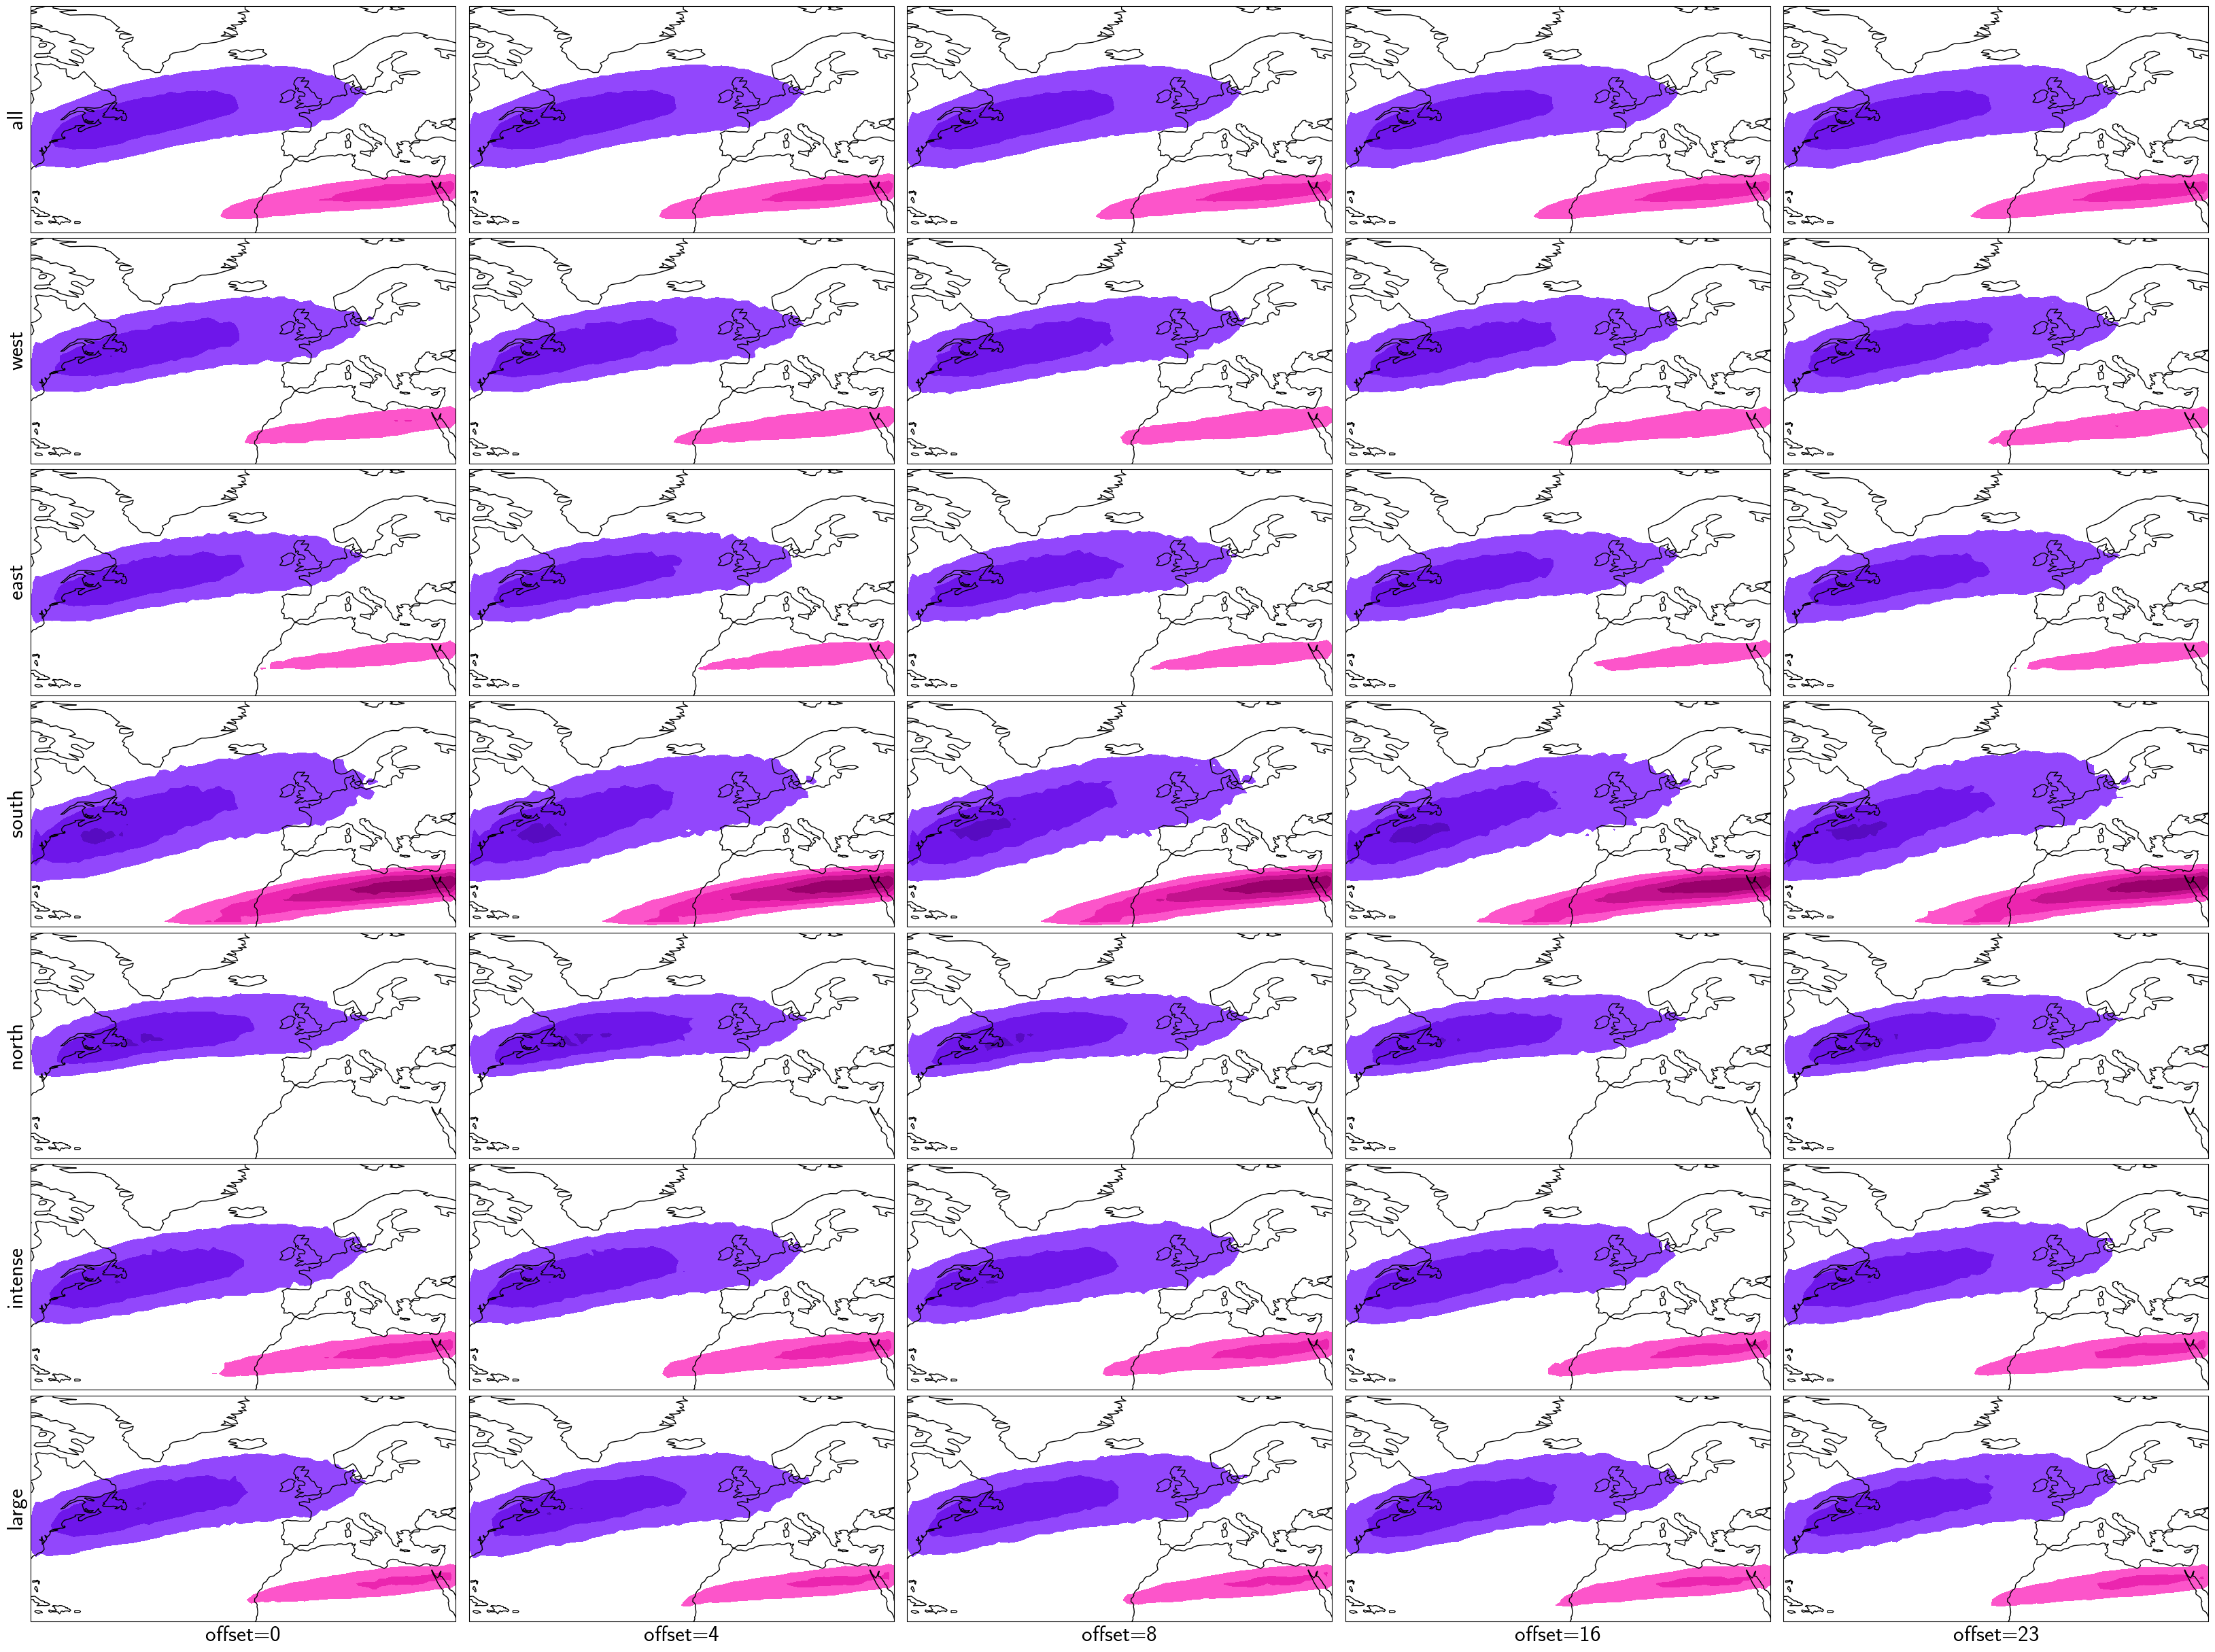

In [69]:
offsets = [0, 4, 8, 16, 23]
clu = Clusterplot(len(da_jp_masked.event_type), len(offsets), region=get_region(da_jp_masked))
_ = clu.add_contourf([da_jp_masked.loc[event_type, offset, 'subtropical'] for event_type in da_jp_masked.event_type for offset in offsets], transparify=2, q=0.99, cmap=MYPINKS, draw_cbar=False)
_ = clu.add_contourf([da_jp_masked.loc[event_type, offset, 'polar'] for event_type in da_jp_masked.event_type for offset in offsets], transparify=2, q=0.99, cmap=MYPURPLES, draw_cbar=False)
for i, event_type in enumerate(da_jp_masked.event_type.values):
    k = len(offsets) * i
    clu.axes[k].set_yticks([])
    clu.axes[k].set_ylabel(event_type, fontsize=24)
for i, offset in enumerate(offsets):
    k = len(offsets) * (len(da_jp_masked.event_type) - 1) + i
    clu.axes[k].set_xticks([])
    clu.axes[k].set_xlabel(f"{offset=}", fontsize=24)

In [92]:
props_as_ds_anoms, props_as_ds_clims = compute_anomalies_ds(props_as_ds, "hourofyear", normalized=True, return_clim=True)

In [93]:
props_as_ds_masked = mask_pvs(props_as_ds_anoms, events, da_anti, np.arange(-24, 25, 4))

100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


In [96]:
fig, axes = plt.subplots(len(props_as_ds_masked.data_vars), 2, figsize=(12, 30), sharex='all', sharey='all', tight_layout=True)
x = props_as_ds_masked.time_around_event.values
colors = ['blue', 'blue', 'green', 'green', 'red', 'purple']
linestyles = ['dashed', 'solid', 'dashed', 'solid', 'solid', 'solid']
for axs, varname in zip(axes, props_as_ds_masked.data_vars):
    for ax, jet in zip(axs, props_as_ds_masked.jet.values):
        da_ = props_as_ds_masked[varname].sel(jet=jet)
        to_plot = da_.loc[dict(event_type="all")]
        ax.plot(x, to_plot.values, lw=3, color='black', zorder=1000)
        if jet == 'subtropical':
            ax.set_ylabel(varname)
        for event_type, color, linestyle in zip(props_as_ds_masked.event_type.values[1:], colors, linestyles):
            y = da_.sel(event_type=event_type).values
            ax.plot(x, y, label=event_type, lw=3, color=color, linestyle=linestyle)
        ax.grid(True)
axes[0, 0].set_title('Subtropical')
axes[0, 1].set_title('Polar')
axes[-1, 0].set_xlabel('Time around event')
axes[-1, 1].set_xlabel('Time around event')
axes[-1, -1].legend(ncol=3)

NameError: name 'props_as_ds_masked' is not defined